# Movielens Recommender
Done via the collaborative filtering approach.

In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline

In [3]:
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [4]:
import os
import numpy as np
import pandas as pd

In [5]:
#path = "data/ml-20m/"
path = "/home/ubuntu/courses/deeplearning1/nbs/kaggle_data/movie_lens/ml-latest-small/"
model_path = path + "models/"
batch_size = 64

## Set up data

In [6]:
ratings = pd.read_csv(path + "ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
movie_names = pd.read_csv(path + "movies.csv")
movie_names.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movie_names = movie_names.set_index("movieId")["title"]
movie_names

movieId
1                                          Toy Story (1995)
2                                            Jumanji (1995)
3                                   Grumpier Old Men (1995)
4                                  Waiting to Exhale (1995)
5                        Father of the Bride Part II (1995)
6                                               Heat (1995)
7                                            Sabrina (1995)
8                                       Tom and Huck (1995)
9                                       Sudden Death (1995)
10                                         GoldenEye (1995)
11                           American President, The (1995)
12                       Dracula: Dead and Loving It (1995)
13                                             Balto (1995)
14                                             Nixon (1995)
15                                  Cutthroat Island (1995)
16                                            Casino (1995)
17                             S

In [9]:
movie_names = movie_names.to_dict()
movie_names

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cit\xc3\xa9 des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkey

In [10]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [11]:
len(users), len(movies)

(671, 9066)

In [12]:
# create a mapping between user ids and the index in the users numpy.ndarray (same for movies, which are not in order)
userid2idx = {o:i for i, o in enumerate(users)}
movieid2idx = {o:i for i, o in enumerate(movies)}

In [13]:
movieid2idx

{1: 417,
 2: 650,
 3: 319,
 4: 2084,
 5: 651,
 6: 652,
 7: 2061,
 8: 2518,
 9: 2062,
 10: 20,
 11: 653,
 12: 3589,
 13: 5017,
 14: 654,
 15: 3633,
 16: 655,
 17: 21,
 18: 2063,
 19: 656,
 20: 2274,
 21: 418,
 22: 657,
 23: 2085,
 24: 2275,
 25: 658,
 26: 503,
 27: 4740,
 28: 3590,
 29: 1944,
 30: 4212,
 31: 0,
 32: 447,
 34: 139,
 35: 2086,
 36: 504,
 37: 4384,
 38: 7691,
 39: 22,
 40: 419,
 41: 3004,
 42: 2087,
 43: 3591,
 44: 659,
 45: 448,
 46: 4131,
 47: 23,
 48: 2088,
 65585: 5393,
 50: 24,
 52: 25,
 53: 6506,
 54: 6867,
 55: 3005,
 57: 2089,
 58: 2090,
 59: 7145,
 60: 96,
 61: 3617,
 62: 26,
 63: 2091,
 64: 2092,
 65: 3401,
 66: 5001,
 68: 3006,
 69: 2481,
 70: 547,
 71: 4463,
 72: 4213,
 73: 2499,
 74: 2064,
 76: 2065,
 77: 7610,
 78: 2478,
 79: 2066,
 80: 5959,
 81: 2067,
 82: 660,
 83: 6323,
 84: 7685,
 85: 2068,
 86: 2069,
 87: 7695,
 88: 2952,
 89: 2093,
 92: 2070,
 93: 4132,
 94: 661,
 95: 662,
 131168: 3519,
 97: 2094,
 98: 3634,
 99: 6452,
 100: 2071,
 101: 663,
 102: 474

In [14]:
# problem was that movie ids were weird - we had things like 5673 and then all of a sudden 577734. We want them all to be
# contiguous (separated by one, because we'll later use them as Embeddings in keras, and apparently that matters)
# so we update the original ratings pd.DataFrame
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])

In [15]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205


In [16]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), ratings.userId.max(), 
                                            ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [17]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [18]:
# let's define the number of latent factors we want to have (how many features a movie has, and user has preferences for)
n_factors = 50
np.random.seed = 42

In [19]:
# split into train and validation randomly, with validation being 20%
msk = np.random.rand(len(ratings)) < 0.8
# the mask just comes up with len(ratings) number of floats between 0-1 and then uses boolean to turn them into True if
# they are above 0.8 and False otherwise
msk

array([False,  True,  True, ...,  True,  True,  True], dtype=bool)

In [20]:
trn = ratings[msk]
val = ratings[~msk]

# we can compare and see that for the same users, rows with ratings for different movies fall into separate sets (trn or val)
trn.head(5)

,userId,movieId,rating,timestamp
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205
6,0,6,2.0,1260759187


In [21]:
val.head(5)

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
5,0,5,2.0,1260759151
7,0,7,2.0,1260759148
12,0,12,4.0,1260759191
15,0,15,2.0,1260759198


## Create crosstab for excel
We'll only want the users who rated most movies and movies who were most rated.

In [22]:
# grab users who rated movies and count how many ratings they made
g = ratings.groupby('userId')['rating'].count()
g

userId
0        20
1        76
2        51
3       204
4       100
5        44
6        88
7       116
8        45
9        46
10       38
11       61
12       53
13       20
14     1700
15       29
16      363
17       51
18      423
19       98
20      162
21      220
22      726
23       21
24       26
25      172
26       23
27       50
28       22
29     1011
       ... 
641      36
642      24
643      39
644      30
645     169
646     150
647     256
648      90
649      29
650      20
651     267
652      51
653     626
654     105
655     128
656      20
657      60
658     142
659      92
660      33
661      58
662      26
663     519
664     434
665      40
666      68
667      20
668      37
669      31
670     115
Name: rating, Length: 671, dtype: int64

In [23]:
top_users = g.sort_values(ascending=False)[:15]
top_users

userId
546    2391
563    1868
623    1735
14     1700
72     1610
451    1340
467    1291
379    1063
310    1019
29     1011
293     947
508     923
579     922
212     910
211     876
Name: rating, dtype: int64

In [24]:
# same for movies
g = ratings.groupby('movieId')['rating'].count()
g

movieId
0        42
1        42
2        33
3        48
4        46
5        48
6        46
7        46
8        52
9        39
10       47
11       46
12       46
13       47
14       36
15       42
16       53
17       47
18       43
19       62
20      122
21       86
22      120
23      201
24      201
25       51
26       87
27      228
28       26
29      200
       ... 
9036      1
9037      1
9038      1
9039      1
9040      1
9041      1
9042      1
9043      1
9044      1
9045      1
9046      1
9047      1
9048      1
9049      1
9050      1
9051      1
9052      1
9053      1
9054      1
9055      1
9056      1
9057      1
9058      1
9059      1
9060      1
9061      1
9062      1
9063      1
9064      1
9065      1
Name: rating, Length: 9066, dtype: int64

In [25]:
top_movies = g.sort_values(ascending=False)[:15]
top_movies

movieId
57     341
49     324
99     311
92     304
143    291
72     274
402    259
417    247
79     244
89     237
179    234
27     228
197    226
505    224
180    220
Name: rating, dtype: int64

In [26]:
top_r = ratings.join(top_users, rsuffix="_r", how="inner", on="userId")

In [27]:
top_r

,userId,movieId,rating,timestamp,rating_r
962,14,417,2.0,997938310,1700
963,14,650,2.0,1134521380,1700
964,14,651,4.5,1093070098,1700
965,14,652,4.0,1040205753,1700
966,14,20,3.0,1093028290,1700
967,14,653,2.5,1093028381,1700
968,14,654,2.5,1166586286,1700
969,14,655,3.5,1093070150,1700
970,14,21,3.0,997939404,1700
971,14,656,1.0,1093028409,1700


In [28]:
top_r = top_r.join(top_movies, rsuffix="_r", how="inner", on="movieId")
top_r

,userId,movieId,rating,timestamp,rating_r,rating_r
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247
40153,293,417,4.0,1047071649,947,247
43329,310,417,3.0,898007830,1019,247
51144,379,417,4.0,1048092869,1063,247
61432,451,417,3.5,1133735252,1340,247
65657,467,417,4.0,1296195523,1291,247


In [29]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Models
### Dot product
The simplest model is just multiplying (dot product) of the latent factors for user and for movie. No bias term.

In [22]:
from keras.layers import Input, Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.engine import merge
from keras.models import Model
from keras.optimizers import Adam

In [23]:
# input layers
user_in = Input(shape=(1,), dtype="int64", name="user_in")
movie_in = Input(shape=(1,), dtype="int64", name="movie_in")

# embeddings
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [24]:
x = merge([u, m], mode="dot")
x = Flatten()(x)

In [25]:
model = Model([user_in, movie_in], x)

In [26]:
model.compile(Adam(0.001), loss='mse')

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80079 samples, validate on 19925 samples
Epoch 1/1
40320/80079 [==============>...............] - ETA: 2s - loss: 13.0599

KeyboardInterrupt: 

In [50]:
model.optimizer.lr = 0.01
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80147 samples, validate on 19857 samples
Epoch 1/5
80147/80147 [==============================] - 6s - loss: 2.6931 - val_loss: 1.7027
Epoch 2/5
80147/80147 [==============================] - 6s - loss: 2.6628 - val_loss: 1.6641
Epoch 3/5
80147/80147 [==============================] - 6s - loss: 2.6328 - val_loss: 1.6830
Epoch 4/5
80147/80147 [==============================] - 6s - loss: 2.6202 - val_loss: 1.6617
Epoch 5/5
80147/80147 [==============================] - 6s - loss: 2.5944 - val_loss: 1.6389


In [54]:
model.optimizer.lr = 0.0001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80147 samples, validate on 19857 samples
Epoch 1/5
80147/80147 [==============================] - 6s - loss: 2.5203 - val_loss: 1.5779
Epoch 2/5
80147/80147 [==============================] - 6s - loss: 2.5144 - val_loss: 1.5596
Epoch 3/5
80147/80147 [==============================] - 6s - loss: 2.5086 - val_loss: 1.5630
Epoch 4/5
80147/80147 [==============================] - 6s - loss: 2.5015 - val_loss: 1.5646
Epoch 5/5
80147/80147 [==============================] - 6s - loss: 2.4941 - val_loss: 1.5666


In [52]:
# best benchmark of loss is around 0.9, so we will try adding bias first to symbolize how some users generally like movies
# and how some movies are generally more popular

### Bias
Let's add bias.

In [28]:
# to do this we'll simply add an embedding with one output for each user and one output for each movie.
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype="int64", name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [29]:
user_in, u = embedding_input("user_in", n_users, n_factors, 1e-4)
movie_in, m = embedding_input("movie_in", n_movies, n_factors, 1e-4)

In [30]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [31]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [32]:
# so first we're merging the 50 factors embedding for both user and movie into a 50x50 matrix (dot multiplication)
x = merge([u, m], mode="dot")

# then we flatten it back into a vector
x = Flatten()(x)

# then we add bias? Yes, we sum bias into the flattened vector (mode="sum") for both movie and user
x = merge([x, ub], mode="sum")
x = merge([x, mb], mode="sum")

# this is already flat

In [33]:
# so now we can build a model which includes our chain of X operations.
model = Model([user_in, movie_in], x)
model.compile(Adam(lr=0.001), loss="mse")

In [41]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80068 samples, validate on 19936 samples
Epoch 1/1
80068/80068 [==============================] - 6s - loss: 3.2653 - val_loss: 1.9352


In [42]:
model.optimizer.lr = 0.01
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80068 samples, validate on 19936 samples
Epoch 1/5
53760/80068 [===================>..........] - ETA: 1s - loss: 2.1361

KeyboardInterrupt: 

In [43]:
model.optimizer.lr = 0.0001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80068 samples, validate on 19936 samples
Epoch 1/5
80068/80068 [==============================] - 6s - loss: 1.8749 - val_loss: 1.2239
Epoch 2/5
80068/80068 [==============================] - 6s - loss: 1.7194 - val_loss: 1.1314
Epoch 3/5
80068/80068 [==============================] - 6s - loss: 1.6319 - val_loss: 1.0875
Epoch 4/5
80068/80068 [==============================] - 6s - loss: 1.5586 - val_loss: 1.0504
Epoch 5/5
80068/80068 [==============================] - 6s - loss: 1.4883 - val_loss: 1.0281


In [44]:
model.optimizer.lr = 0.00001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80068 samples, validate on 19936 samples
Epoch 1/5
80068/80068 [==============================] - 6s - loss: 1.4203 - val_loss: 1.0042
Epoch 2/5
80068/80068 [==============================] - 6s - loss: 1.3550 - val_loss: 0.9823
Epoch 3/5
19840/80068 [======>.......................] - ETA: 4s - loss: 1.2615

KeyboardInterrupt: 

In [45]:
model.optimizer.lr = 0.0001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 80068 samples, validate on 19936 samples
Epoch 1/5
80068/80068 [==============================] - 6s - loss: 1.2791 - val_loss: 0.9567
Epoch 2/5
11584/80068 [===>..........................] - ETA: 4s - loss: 1.1616

KeyboardInterrupt: 

In [74]:
model.save_weights(model_path + "/bias.h5")

In [34]:
model.load_weights(model_path + "/bias.h5")

In [35]:
# this would predict how well user 3 might rate movie 6
model.predict([np.array([3]), np.array([12])])

# on a scale of 1-5 4.7 is liking the movie a lot

array([[ 4.5821]], dtype=float32)

In [36]:
# I had to check a couple movies before finding one that this user has already rated, apparently we're close.
# note that I had to use df.loc[()] and logical coniditions have to be done wih & and |, not and and or.
ratings.loc[(ratings["userId"] == 3) & (ratings["movieId"] == 12)]

# df.loc[(df['column_name'] == some_value) & df['other_column'].isin(some_values)]

,userId,movieId,rating,timestamp
251,3,12,5.0,949810261


### Analyze the results (PCA)
We'll see what we've done and then try to boil down the 50 factors into some more understandable groups.

In [37]:
# first, let's restrict our search to top 2000 most popular movies (count how often they were rated)
g = ratings.groupby("movieId")["rating"].count()
topMovies = g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [38]:
topMovies

array([  57,   49,   99, ..., 3436, 1804, 1793])

In [39]:
type(mb)

theano.tensor.var.TensorVariable

In [40]:
# in order to see what movies are generally liked we take a look at the value of bias our model outputs for a given movie
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)

# ok, so movie_names[movies[i]] correctly grabs the title and the zip part just matches top movie to its bias, gotten above.
# b[0] is only there because b alone also returns dtype=float32 along the bias
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]
movie_ratings

[(1.0999212, 'Forrest Gump (1994)'),
 (1.0885161, 'Pulp Fiction (1994)'),
 (1.2482903, 'Shawshank Redemption, The (1994)'),
 (1.0325881, 'Silence of the Lambs, The (1991)'),
 (0.88329321, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.84605265, 'Jurassic Park (1993)'),
 (0.83968931, 'Matrix, The (1999)'),
 (0.75292569, 'Toy Story (1995)'),
 (1.0672287, "Schindler's List (1993)"),
 (0.89707994, 'Terminator 2: Judgment Day (1991)'),
 (0.98064631, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.90948898, 'Braveheart (1995)'),
 (0.87467659, 'Back to the Future (1985)'),
 (1.0547364, 'Fargo (1996)'),
 (0.77314788,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.84525794, 'American Beauty (1999)'),
 (0.84581232, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.69794583, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.69215512, 'Aladdin (1992)'),
 (1.0658534, 'Fugitive, The (1993)'),
 (0.88937485, 'Fight Club (1999)'),
 (0.783243

In [41]:
# let's sort them, look at bottom 15
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.29856682, 'Battlefield Earth (2000)'),
 (-0.14425622, 'Jaws 3-D (1983)'),
 (-0.026404209, 'Speed 2: Cruise Control (1997)'),
 (0.0014719963, 'Police Academy 6: City Under Siege (1989)'),
 (0.030182082, 'Blade: Trinity (2004)'),
 (0.030663323, 'Little Nicky (2000)'),
 (0.034528166, 'Spice World (1997)'),
 (0.057184145, 'Avengers, The (1998)'),
 (0.062784046, 'Wild Wild West (1999)'),
 (0.063078314, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.067940086, 'Batman & Robin (1997)'),
 (0.083988503, 'Haunting, The (1999)'),
 (0.089708649, 'End of Days (1999)'),
 (0.10907386, 'Blair Witch Project, The (1999)'),
 (0.10927715, 'Two Weeks Notice (2002)')]

In [42]:
# best one
sorted(movie_ratings, key=itemgetter(0))[-15:]

[(1.2253265, 'Professional, The (Le professionnel) (1981)'),
 (1.240289, 'Cyrano de Bergerac (1990)'),
 (1.241271, 'Thirty-Two Short Films About Glenn Gould (1993)'),
 (1.2426498, 'Three Colors: Red (Trois couleurs: Rouge) (1994)'),
 (1.2465332, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2482903, 'Shawshank Redemption, The (1994)'),
 (1.250082, 'Blood Diamond (2006)'),
 (1.2541806,
  'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)'),
 (1.2614627, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2616092, 'Tom Jones (1963)'),
 (1.2648426, 'Ideal Husband, An (1999)'),
 (1.2792085, '21 Jump Street (2012)'),
 (1.3794479, 'Michael Clayton (2007)'),
 (1.4060533, 'Rush (2013)'),
 (1.4106588, 'Argo (2012)')]

In [43]:
# but the order was reversed so let's do this properly
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4106588, 'Argo (2012)'),
 (1.4060533, 'Rush (2013)'),
 (1.3794479, 'Michael Clayton (2007)'),
 (1.2792085, '21 Jump Street (2012)'),
 (1.2648426, 'Ideal Husband, An (1999)'),
 (1.2616092, 'Tom Jones (1963)'),
 (1.2614627, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2541806,
  'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)'),
 (1.250082, 'Blood Diamond (2006)'),
 (1.2482903, 'Shawshank Redemption, The (1994)'),
 (1.2465332, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2426498, 'Three Colors: Red (Trois couleurs: Rouge) (1994)'),
 (1.241271, 'Thirty-Two Short Films About Glenn Gould (1993)'),
 (1.240289, 'Cyrano de Bergerac (1990)'),
 (1.2253265, 'Professional, The (Le professionnel) (1981)')]

#### Same for embeddings
We can also look at the embeddings output by our model for the top 2K most popular movies.

In [44]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb

array([[ 0.1832, -0.4397,  0.2058, ...,  0.2826, -0.0053, -0.214 ],
       [ 0.0627,  0.1564,  0.3854, ...,  0.266 ,  0.3354, -0.3846],
       [ 0.1603, -0.2213,  0.2225, ...,  0.2976,  0.0939, -0.4621],
       ..., 
       [ 0.0346, -0.0303,  0.0599, ...,  0.0358,  0.0752,  0.0171],
       [-0.0069, -0.0504,  0.0059, ...,  0.0145,  0.0316, -0.0268],
       [ 0.0144, -0.3953,  0.0556, ..., -0.0063,  0.0507, -0.0142]], dtype=float32)

In [45]:
movie_emb.shape

(2000, 50)

In [46]:
# that's all good, but 50 dimensions are a little hard to interpret so let's use PCA to break them down to 4-5 (instead of
# the 3 in example)

## PCA
Breaking down into fewer dimensions

In [47]:
movie_emb.shape

(2000, 50)

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

# not sure why we transpose (movie_emb.T) - I think it's because we want 4 dimensions for each move, 
# so 4 rows and then like 2000 columns
movie_pca = pca.fit(movie_emb.T).components_

In [49]:
movie_pca.shape

(4, 2000)

### Fac1 (cult status)

In [50]:
# let's look at the first principal component / facet
fac1 = movie_pca[0]
fac1.shape

(2000,)

In [51]:
# grab the value of this facet for all top movies and tie it with the title of the movie
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

In [52]:
# now sort and see
sorted(movie_comp, key=itemgetter(0))[:15]

[(-0.015403371, 'Anaconda (1997)'),
 (-0.010819175, 'Battlefield Earth (2000)'),
 (-0.0088238735, 'Jaws 3-D (1983)'),
 (-0.007726219, 'Island of Dr. Moreau, The (1996)'),
 (-0.0071239332, 'Blade: Trinity (2004)'),
 (-0.0068007, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.0059808367, 'Godzilla (1998)'),
 (-0.0056544803, "You Don't Mess with the Zohan (2008)"),
 (-0.0055884882, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0052958354, 'Police Academy 3: Back in Training (1986)'),
 (-0.0050865221, 'House on Haunted Hill (1999)'),
 (-0.00471693, 'Gremlins 2: The New Batch (1990)'),
 (-0.0046812058, 'Son in Law (1993)'),
 (-0.0042754421, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.0038758642, 'Hollow Man (2000)')]

In [53]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(0.049582392, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.04952627, 'Shawshank Redemption, The (1994)'),
 (0.049487174, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.048683591, 'Usual Suspects, The (1995)'),
 (0.048342708, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.048113707, 'Toy Story (1995)'),
 (0.047577955, 'Monty Python and the Holy Grail (1975)'),
 (0.047144078,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.046740048, 'Good Will Hunting (1997)'),
 (0.046390947, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (0.045849476, 'Princess Bride, The (1987)'),
 (0.045802869, 'American Beauty (1999)'),
 (0.045622714, 'Run Lola Run (Lola rennt) (1998)'),
 (0.045540173, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.045535397, 'Wallace & Gromit: A Close Shave (1995)')]

In [54]:
# ok, so fac1 seems to be about critically acclaime or cult/very popular

### Fac2 - action vs drama

In [55]:
fac2 = movie_pca[1]
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac2, topMovies)]
sorted(movie_comp, key=itemgetter(0))[:15]

[(-0.090535671, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.086482242, 'Armageddon (1998)'),
 (-0.075243473, 'Titanic (1997)'),
 (-0.073076323, 'Rock, The (1996)'),
 (-0.072721682, 'Ghost (1990)'),
 (-0.07092046, 'Jurassic Park (1993)'),
 (-0.070094407, 'Braveheart (1995)'),
 (-0.069725238, 'Speed (1994)'),
 (-0.069041766, 'Twister (1996)'),
 (-0.067971043, 'X-Men (2000)'),
 (-0.067818813, 'Batman Forever (1995)'),
 (-0.066861346, 'Stargate (1994)'),
 (-0.066781133, 'True Lies (1994)'),
 (-0.065103322, 'Waterworld (1995)'),
 (-0.065071039, 'Ace Ventura: When Nature Calls (1995)')]

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(0.060409926, 'City Lights (1931)'),
 (0.056661934, '2001: A Space Odyssey (1968)'),
 (0.054709978, 'Manhattan (1979)'),
 (0.053948052, 'Apocalypse Now (1979)'),
 (0.051412579, 'Clockwork Orange, A (1971)'),
 (0.050951939, "Miller's Crossing (1990)"),
 (0.050293233, 'Royal Tenenbaums, The (2001)'),
 (0.05016904, 'Annie Hall (1977)'),
 (0.050020866, 'Lost in Translation (2003)'),
 (0.049811542, 'Mulholland Drive (2001)'),
 (0.049791869, 'Bringing Up Baby (1938)'),
 (0.048768651, 'Taxi Driver (1976)'),
 (0.048722886, 'Wild Bunch, The (1969)'),
 (0.048682269, 'Chinatown (1974)'),
 (0.048650213, 'Brokeback Mountain (2005)')]

### Fac3 (serious vs lighter)

In [57]:
fac3 = movie_pca[2]
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac3, topMovies)]
sorted(movie_comp, key=itemgetter(0))[:15]

[(-0.11382648, 'Silence of the Lambs, The (1991)'),
 (-0.11359119, "Schindler's List (1993)"),
 (-0.11208723, 'Fargo (1996)'),
 (-0.097312421, 'Braveheart (1995)'),
 (-0.092616126, 'Speed (1994)'),
 (-0.090970673, 'Lion King, The (1994)'),
 (-0.090491988, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.090424821, 'Dances with Wolves (1990)'),
 (-0.0887013, 'Babe (1995)'),
 (-0.084751345, 'Jurassic Park (1993)'),
 (-0.079694979, 'Home Alone (1990)'),
 (-0.077555642, 'Rob Roy (1995)'),
 (-0.076615453, 'Fugitive, The (1993)'),
 (-0.076007724, 'Apollo 13 (1995)'),
 (-0.074931018, 'Mrs. Doubtfire (1993)')]

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(0.064341977, 'Boondock Saints, The (2000)'),
 (0.063588552, 'Serenity (2005)'),
 (0.06042362, 'American Psycho (2000)'),
 (0.058929894, 'Miss Congeniality (2000)'),
 (0.056082696, 'Little Miss Sunshine (2006)'),
 (0.055663053, "Pirates of the Caribbean: Dead Man's Chest (2006)"),
 (0.055653125, 'Lock, Stock & Two Smoking Barrels (1998)'),
 (0.055172455, 'Dirty Rotten Scoundrels (1988)'),
 (0.054987445, 'Elf (2003)'),
 (0.053985637, 'Evolution (2001)'),
 (0.053221323, 'From Dusk Till Dawn (1996)'),
 (0.052049872, 'Taken (2008)'),
 (0.051984839, 'Charlie and the Chocolate Factory (2005)'),
 (0.050099265, 'Tangled (2010)'),
 (0.050025359, 'Harry Potter and the Chamber of Secrets (2002)')]

### Fac4 (romantic vs action)

In [59]:
fac4 = movie_pca[3]
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac4, topMovies)]
sorted(movie_comp, key=itemgetter(0))[:15]

[(-0.083602235, 'Sabrina (1995)'),
 (-0.079264596, 'Beauty and the Beast (1991)'),
 (-0.075716875, 'Babe (1995)'),
 (-0.071619324, "You've Got Mail (1998)"),
 (-0.071149237, 'Sense and Sensibility (1995)'),
 (-0.067745417, 'Wag the Dog (1997)'),
 (-0.064550944, "Romy and Michele's High School Reunion (1997)"),
 (-0.064426377, 'Phenomenon (1996)'),
 (-0.062368158, 'While You Were Sleeping (1995)'),
 (-0.062361386, 'Bend It Like Beckham (2002)'),
 (-0.061266527, 'Sleepless in Seattle (1993)'),
 (-0.058167387, 'Nell (1994)'),
 (-0.056383174, 'Mrs. Doubtfire (1993)'),
 (-0.056171753, 'Twister (1996)'),
 (-0.05570925, 'Shakespeare in Love (1998)')]

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(0.1132949, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.099067628, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.088850752, 'Matrix, The (1999)'),
 (0.088799439, 'Seven (a.k.a. Se7en) (1995)'),
 (0.082966864, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.08012744, 'Aliens (1986)'),
 (0.077267632, 'Fight Club (1999)'),
 (0.071659021, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.071430705, 'Spaceballs (1987)'),
 (0.068432979, 'Happy Gilmore (1996)'),
 (0.064017281, '300 (2007)'),
 (0.063477099, 'Kill Bill: Vol. 1 (2003)'),
 (0.063008793, 'Silence of the Lambs, The (1991)'),
 (0.061033405, 'Mad Max: Fury Road (2015)'),
 (0.057844598, 'Dark Knight, The (2008)')]

In [61]:
# we can also draw a picture
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

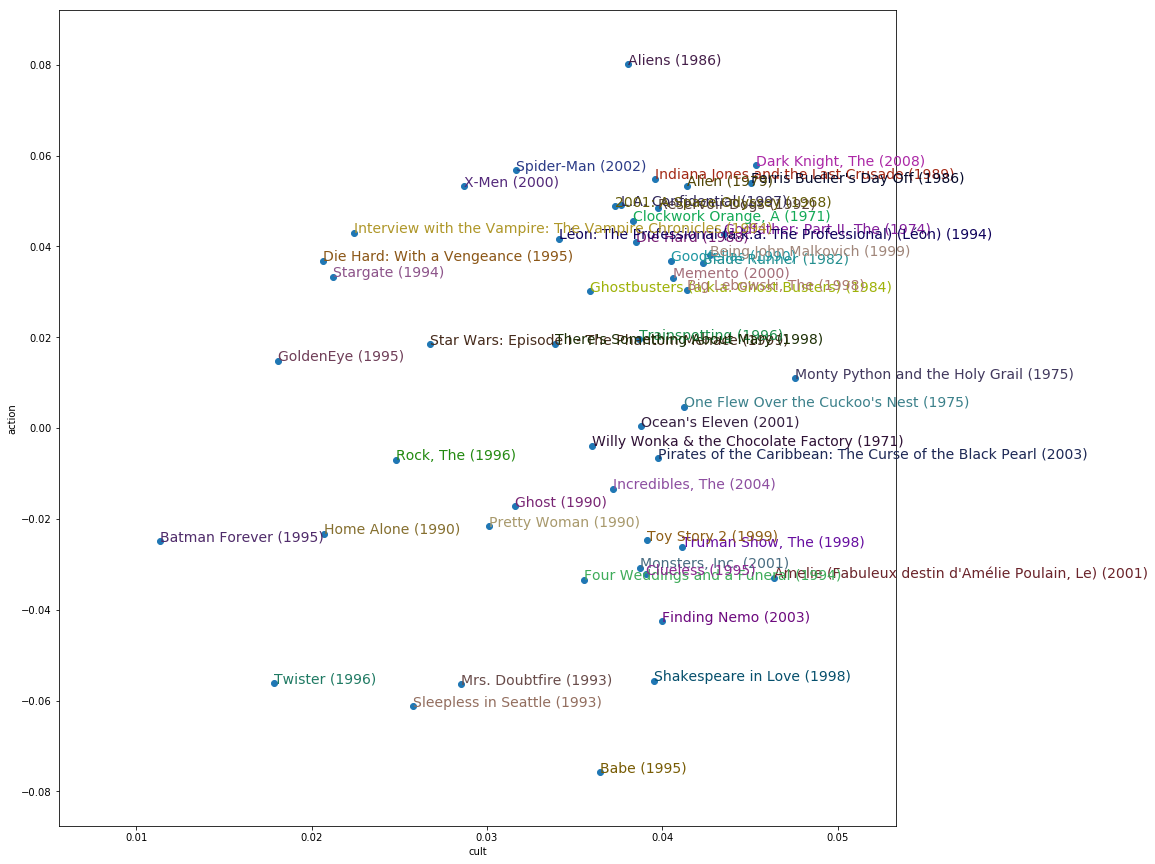

In [64]:
import matplotlib.pyplot as plt
start=50; end=100
X = fac1[start:end]
Y = fac4[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
plt.xlabel('cult')
plt.ylabel('action')
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

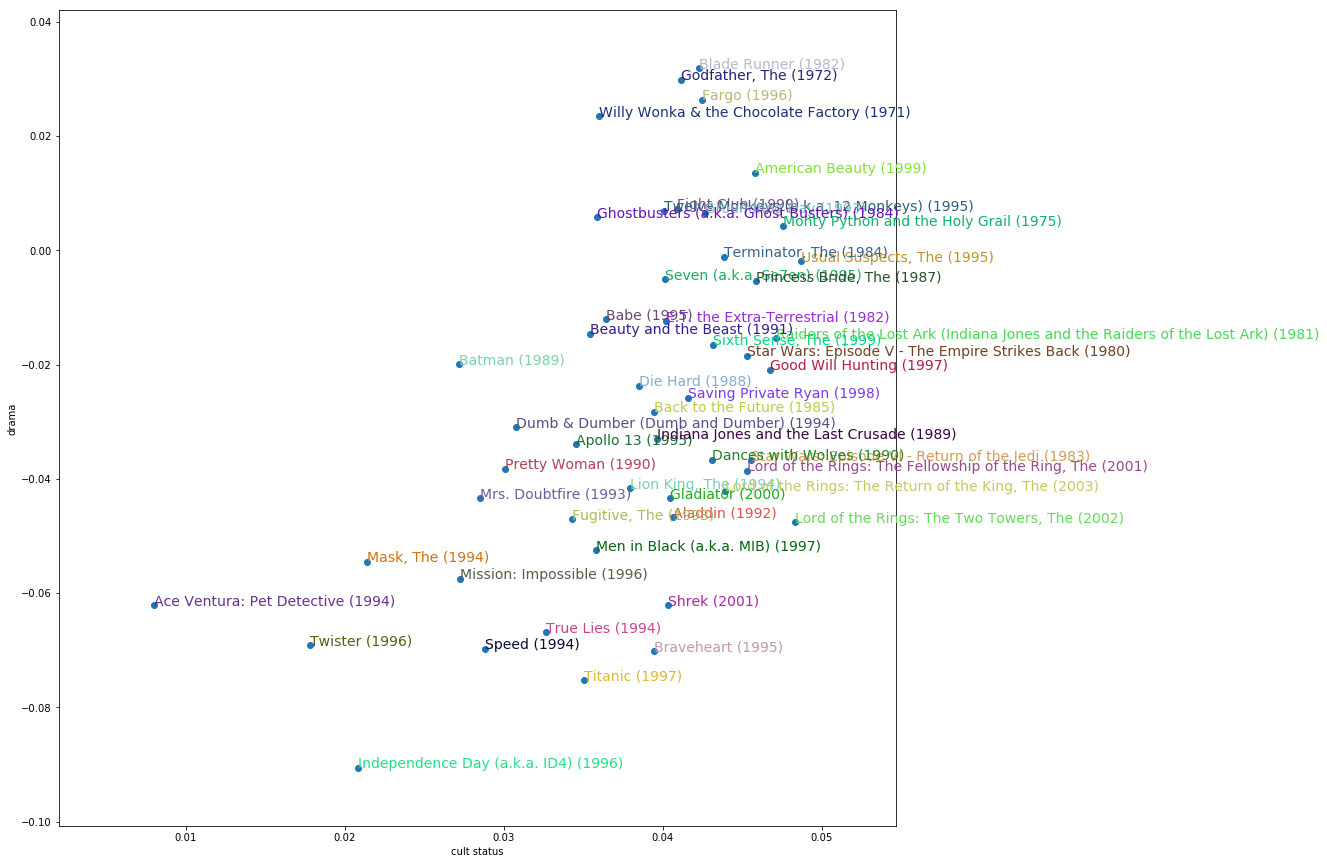

In [74]:
from matplotlib import pyplot as plt
start = 10
end = 60
X = fac1[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)
plt.xlabel("cult status")
plt.ylabel("drama")
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], fontsize=14, color=np.random.rand(3) * 0.9)

### Neural Network
Rather than creating the dot product thingy it's often easier to use a simple NN architecture. Let's do that:


In [75]:
# we can simply concatenate the user and movie embeddings into one vector and pass it as input
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

user_in, u = embedding_input("user_in", n_users, n_factors, 1e-4)
movie_in, m = embedding_input("movie_in", n_movies, n_factors, 1e-4)

In [76]:
x = merge([u,m], mode="concat")
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation="relu")(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(lr=0.001), loss="mse")

In [77]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1,
      validation_data=([val.userId, val.movieId], val.rating))

Train on 80079 samples, validate on 19925 samples
Epoch 1/1
80079/80079 [==============================] - 7s - loss: 2.4888 - val_loss: 0.9034


In [87]:
nn.optimizer.lr = 0.000001
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
      validation_data=([val.userId, val.movieId], val.rating))

Train on 80079 samples, validate on 19925 samples
Epoch 1/5
80079/80079 [==============================] - 7s - loss: 0.7847 - val_loss: 0.7725
Epoch 2/5
80079/80079 [==============================] - 7s - loss: 0.7834 - val_loss: 0.7743
Epoch 3/5
80079/80079 [==============================] - 7s - loss: 0.7817 - val_loss: 0.7750
Epoch 4/5
80079/80079 [==============================] - 7s - loss: 0.7805 - val_loss: 0.7751
Epoch 5/5
80079/80079 [==============================] - 7s - loss: 0.7814 - val_loss: 0.7763


In [86]:
nn.optimizer.lr = 0.001
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3,
      validation_data=([val.userId, val.movieId], val.rating))

Train on 80079 samples, validate on 19925 samples
Epoch 1/3
80079/80079 [==============================] - 7s - loss: 0.7867 - val_loss: 0.7727
Epoch 2/3
80079/80079 [==============================] - 7s - loss: 0.7841 - val_loss: 0.7725
Epoch 3/3
80079/80079 [==============================] - 7s - loss: 0.7854 - val_loss: 0.7759


In [83]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,
      validation_data=([val.userId, val.movieId], val.rating))

Train on 80079 samples, validate on 19925 samples
Epoch 1/5
80079/80079 [==============================] - 7s - loss: 0.7905 - val_loss: 0.7765
Epoch 2/5
80079/80079 [==============================] - 7s - loss: 0.7884 - val_loss: 0.7777
Epoch 3/5
80079/80079 [==============================] - 7s - loss: 0.7898 - val_loss: 0.7754
Epoch 4/5
80079/80079 [==============================] - 7s - loss: 0.7903 - val_loss: 0.7751
Epoch 5/5
80079/80079 [==============================] - 7s - loss: 0.7871 - val_loss: 0.7762


In [88]:
nn.predict([np.array([3]), np.array([12])])

array([[ 4.5952]], dtype=float32)

In [81]:
nn.save_weights(model_path + "nn_weights.b5")

In [82]:
nn.load_weights(model_path + "nn_weights.b5")

### Look at the visualisations more and experiment with the output of the neural network more